In [1]:
# filename: knn.ipynb
# purpose: knn model implement

# OHT KNN model implement

### KNN implements
- KNN classification method will be used to detect abnormal,outlier data

### Processing flow
- Read mixed dataset from dukdb table
- Reduce dataset to the required volumn
- Convert int label in flag column to str label for easier understaing of the classification report
- Split training and test dataset and labels
- Search best-K value in the configured neighbor range 
- KNN train with the searched best K value 
- Predict with test dataset
- Report the prediction report with best-K, accuracy score, confusion matrix (precision,recall,f-score,support)
- Chart confunsion matrix by heatmap
- Chart decision boundary scatter with 2 features
  

In [2]:
# packages
import time
import os
import tempfile
import numpy as np
import pandas as pd
import humanfriendly as human

import joblib

import ohtconf as conf
import ohtcomm as comm
import ohtkml as kml

## Main

In [3]:
mainstart = time.time()

In [4]:
# set float display format
pd.set_option("display.float_format", "{:.1f}".format)

In [5]:
# read table data
_start = time.time()

dfmix = comm.read_tabdf(conf.TABNAME_MIX)
dfmix.sort_values(by=conf.COLUMN_NAMES[0], inplace=True)
dfmix.reset_index(drop=True, inplace=True)

dfknn = dfmix.iloc[0 : conf.TRAIN_SIZE]  # execution time key factor

# type convert to prevent model fit, RuntimeWarning: invalid value encountered in cast
type_dict = {col: np.float32 for col in conf.COLUMN_GRAPH}
dfknn = dfknn.astype(type_dict)

print(f"row count, dfmix={len(dfmix)}, dfknn={len(dfknn)}, expected dfknn={conf.TRAIN_SIZE}")

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

row count, dfmix=108000, dfknn=108000, expected dfknn=800000
elapsed time: 0.1 seconds


### KNN modeling with all 10 features

In [6]:
# knn training
_start = time.time()

# data  feature, column name and labels for flag column value
ALL_ILABELS = list(range(0, 11))  # 0 ~ 10 for normal, outlier-tem,...,outlier-ct4 flag
ALL_COLUMNS = conf.COLUMN_GRAPH
ALL_LABELS = ["NORM"] + ALL_COLUMNS  # NORM for normal, others are for outlier

# data
X = dfknn.loc[:, ALL_COLUMNS]

# label
y = dfknn.loc[:, [conf.COLUMN_FLAG]].copy()  # dataframe
y = y[conf.COLUMN_FLAG]  # series
y = kml.make_strlabel(
    y, ALL_ILABELS, ALL_LABELS
)  # map y, number labels(0~10) to str labels (NORM,TEM,...,CT3) for easier report understanding


best_k, model, X_test, y_test = kml.train(X, y, ALL_COLUMNS, ALL_LABELS, neighbors=kml.calc_neighbors(y))

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

param_grid={'n_neighbors': [14, 24, 25, 28, 39, 42, 46, 92, 97, 105]}
Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END ....................n_neighbors=14;, score=0.968 total time=   1.8s
[CV 2/4] END ....................n_neighbors=14;, score=0.968 total time=   1.9s
[CV 3/4] END ....................n_neighbors=14;, score=0.968 total time=   2.2s
[CV 4/4] END ....................n_neighbors=14;, score=0.966 total time=   1.8s
[CV 1/4] END ....................n_neighbors=24;, score=0.968 total time=   2.2s
[CV 2/4] END ....................n_neighbors=24;, score=0.967 total time=   2.1s
[CV 3/4] END ....................n_neighbors=24;, score=0.964 total time=   2.1s
[CV 4/4] END ....................n_neighbors=24;, score=0.965 total time=   2.3s
[CV 1/4] END ....................n_neighbors=25;, score=0.967 total time=   2.0s
[CV 2/4] END ....................n_neighbors=25;, score=0.967 total time=   2.1s
[CV 3/4] END ....................n_neighbors=25;, score=0.9

In [7]:
# knn predict
_start = time.time()

y_pred = kml.predict(model, X_test)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

elapsed time: 2.53 seconds


In [8]:
# knn report

dfcm = kml.report(best_k, y_test, y_pred, ALL_LABELS, title="all 10 features")


*** Start of KNN modeling report for all 10 features ***


Best K = 42

Accuracy Score =  0.9701388888888889

Confusion Matrix :
         NORM  TEM  PM1  PM2_5  PM10   CO  NH3  CT1  CT2  CT3  CT4
NORM   16159    0    0      0     2    2    0    0    0    0    0
TEM       17  468    4      4     0    0    1    7   16   13   10
PM1       14    0  478      1     0    0    0    4    4    6    5
PM2_5     19    0    4    471     0    0    0    6   13   13   12
PM10      32    0    1      0   495    0    0    3    4    9    4
CO        32    0    0      0     0  533    0    0    0    0    0
NH3       34    0    4      2     0    0  506    6    4    9    6
CT1       20    0    3      2     0    0    0  463   20   22   10
CT2       37    0    5      2     0    0    0   10  471    6   12
CT3       44    0    2      1     0    0    0    6   13  460   12
CT4       32    0    4      3     0    0    1   12   24   15  451

Classification Report :
               precision    recall  f1-score   suppo

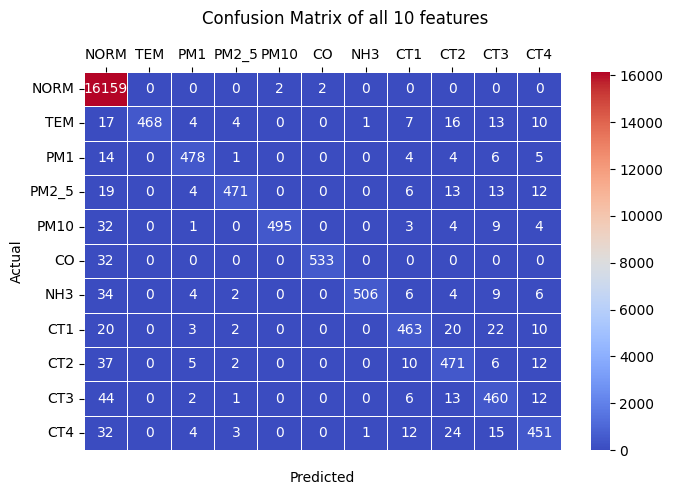

elapsed time: 3.33 seconds


In [9]:
# knn confusion matrix heatmap chart
start = time.time()

pngfile = "knn-cm-heatmap-all.png"
kml.cm_heatmap(dfcm, title="all 10 features", pngfile=pngfile)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

### KNN trainned model usage example 
- save trainned model to a file by the trainning program
- load the saved model by another predicting program
- do predicting

In [10]:
# Save model to a named temporary file
temp_joblib_file = None
with tempfile.NamedTemporaryFile(prefix="knn-model-all_", suffix=".joblib", dir=None, delete=False) as temp_file:
    joblib.dump(model, temp_file)
    temp_joblib_file = temp_file.name
    print(f"Temporary joblib file created: {temp_joblib_file}")

Temporary joblib file created: C:\Users\user\AppData\Local\Temp\knn-model-all_y1d861fe.joblib


In [11]:
# Load the model from the file
load_model = joblib.load(temp_joblib_file)
print(f"Temporary joblib file loaded: {temp_joblib_file}")

load_test = X_test.iloc[0:1]
expect_y = y_pred[0:1]
print(f"load model test data:\n{load_test.to_string()}")

predict_y = kml.predict(load_model, load_test)
if predict_y[0] == expect_y[0]:
    print(f"loaded model predicted value match with expected value: {predict_y[0]}, {expect_y[0]}")
else:
    print(f"loaded model predicted value unmatch with expected value: {predict_y[0]}, {expect_y[0]}")

Temporary joblib file loaded: C:\Users\user\AppData\Local\Temp\knn-model-all_y1d861fe.joblib
load model test data:
       TEM  PM1  PM2_5  PM10    CO  NH3  CT1  CT2  CT3  CT4
36349 40.6 13.0   13.0  15.0 162.0 89.0  0.9  1.0  0.4  0.5
loaded model predicted value match with expected value: NORM, NORM


In [12]:
# Delete the model file
os.remove(temp_joblib_file)
print(f"Temporary joblib file deleted: {temp_joblib_file}")

Temporary joblib file deleted: C:\Users\user\AppData\Local\Temp\knn-model-all_y1d861fe.joblib


### KNN modeling with 2 features for 2-D visualization 

In [13]:
_start = time.time()

# data  feature, column name and labels for flag column value
TWO_ILABELS = [0, 1, 6]  # 0 for normal, 1 for outlier-tem, 6 for outlier-nh3
TWO_COLUMNS = [conf.COLUMN_NAMES[TWO_ILABELS[1]], conf.COLUMN_NAMES[TWO_ILABELS[2]]]
TWO_LABELS = ["NORM"] + TWO_COLUMNS  # NORM for normal, other are for outlier

# data
X = dfknn.loc[:, TWO_COLUMNS]

# label
y = dfknn.loc[:, [conf.COLUMN_FLAG]].copy()  # dataframe
# clear non-candidate column's flag value
y.loc[(y[conf.COLUMN_FLAG] != TWO_ILABELS[1]) & (y[conf.COLUMN_FLAG] != TWO_ILABELS[2]), conf.COLUMN_FLAG] = 0
y = y[conf.COLUMN_FLAG]  # series
# map y, label values TWO_INDEXES to TWO_LABELS
y = kml.make_strlabel(y, TWO_ILABELS, TWO_LABELS)

best_k, model, X_test, y_test = kml.train(X, y, TWO_COLUMNS, TWO_LABELS, neighbors=kml.calc_neighbors(y))

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

param_grid={'n_neighbors': [3, 5, 6, 7, 8, 9]}
Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4] END .....................n_neighbors=3;, score=0.991 total time=   2.0s
[CV 2/4] END .....................n_neighbors=3;, score=0.992 total time=   2.2s
[CV 3/4] END .....................n_neighbors=3;, score=0.991 total time=   2.0s
[CV 4/4] END .....................n_neighbors=3;, score=0.992 total time=   2.3s
[CV 1/4] END .....................n_neighbors=5;, score=0.991 total time=   2.0s
[CV 2/4] END .....................n_neighbors=5;, score=0.992 total time=   2.3s
[CV 3/4] END .....................n_neighbors=5;, score=0.991 total time=   1.9s
[CV 4/4] END .....................n_neighbors=5;, score=0.992 total time=   2.0s
[CV 1/4] END .....................n_neighbors=6;, score=0.991 total time=   2.0s
[CV 2/4] END .....................n_neighbors=6;, score=0.992 total time=   2.0s
[CV 3/4] END .....................n_neighbors=6;, score=0.991 total time=   2.0s
[C

In [14]:
# knn predict
_start = time.time()

y_pred = kml.predict(model, X_test)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

elapsed time: 2.51 seconds


In [15]:
# knn report

dfcm = kml.report(best_k, y_test, y_pred, TWO_LABELS, title=" & ".join(TWO_COLUMNS))


*** Start of KNN modeling report for TEM & NH3 ***


Best K = 3

Accuracy Score =  0.9919444444444444

Confusion Matrix :
        NORM  TEM  NH3
NORM  20485    0    4
TEM      60  480    0
NH3     110    0  461

Classification Report :
               precision    recall  f1-score   support

        NORM       0.99      1.00      1.00     20489
         TEM       1.00      0.89      0.94       540
         NH3       0.99      0.81      0.89       571

    accuracy                           0.99     21600
   macro avg       0.99      0.90      0.94     21600
weighted avg       0.99      0.99      0.99     21600


*** End of KNN modeling report for TEM & NH3 ***



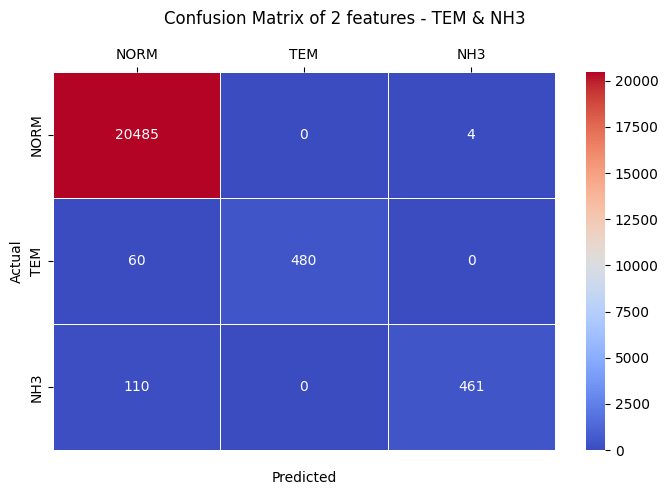

elapsed time: 3.16 seconds


In [16]:
# knn confusion matrix heatmap chart
start = time.time()

pngfile = f"knn-cm-heatmap-{'-'.join(TWO_COLUMNS)}.png"
kml.cm_heatmap(dfcm, title=f"2 features - {' & '.join(TWO_COLUMNS)}", pngfile=pngfile)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

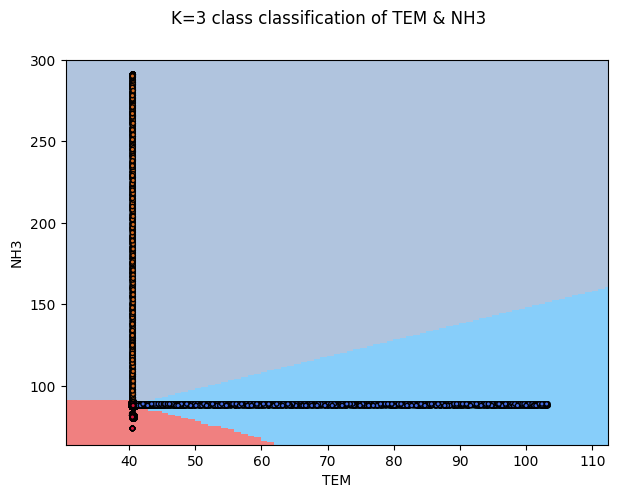

elapsed time: 5.82 seconds


In [17]:
# knn decision boundary scatter, 2-D visualization
start = time.time()

pngfile = f"knn-db-scatter-{'-'.join(TWO_COLUMNS)}.png"
kml.f2_boundary_scatter(X, y, model, best_k, title=" & ".join(TWO_COLUMNS), pngfile=pngfile)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

In [18]:
_elapsed = time.time() - mainstart
print(f"main elapsed time: {human.format_timespan(_elapsed)}")

main elapsed time: 2 minutes and 44.36 seconds


### eof